## Моделирование молекулярной динамики

   - Система: ГЦК решётка $7\times7\times7$ частиц;
   - Постоянная решётки: $a = 1.75~\sigma $;
   - Потенциал взаимодействия: Леннард-Джонс;
   - Начальная температура: $T_i = 1.0~\varepsilon / k_B$;
   - Конечная температура: $T_f = 10^{-10}~\varepsilon / k_B$;
   - Скорость охлаждения: $v_T = 0.001~\varepsilon / k_B\tau$;
   - Баростат: Velocity Scaling;
   - Толщина сферического слоя (список Верле): $\Delta r_s = 0.3~\sigma $;
   - Временной шаг: $\Delta t = 0.005~\tau$;
   - Число шагов для охлаждения: 40000;
   - Функция радиального распределения, среднеквадратичное смещение и коэффициенты самодиффузии рассчитывалась через каждые 2500 шагов;
   - Подсчёт состоял из 2499 шагов: 500 на уравновешивание системы при фиксированной температуре и 1999 на усреднение по ансамблям (к первому ансамблю относятся шаги с 1 по 1000 шаг, ко второму - с 2 по 1001 и т.д.);
   - Функция радиального распределения вычислялась как среднее по времени за первые 1000 шагов;

#### Импорт необходимых библиотек

In [1]:
from copy import deepcopy
from datetime import datetime
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#### Настройки рисунков

In [2]:
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.figsize'] = [i / 2.54 for i in (15, 15)]
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['mathtext.it'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['font.size'] = 14

COLORS = (
    'black',
    'red',
    'green',
    'blue',
    'cyan',
    'magenta',
    'purple',
    'orange',
    'olive',
    'yellow',
    'brown',
    'pink',
    'gray',
    'lime',
    'slateblue',
    'crimson',
    'darkviolet',
    'sienna',
    'coral',
)

#### Путь к файлам с данными

In [3]:
BASE_DIRECTORY = os.path.dirname(os.getcwd())
PATH_TO_DATA = os.path.join(BASE_DIRECTORY, 'data')
PATH_TO_PLOTS = os.path.join(BASE_DIRECTORY, 'plots')

CURRENT_DATA = '2021-02-09_slow'

PATH_TO_CURRENT_DATA = os.path.join(PATH_TO_DATA, CURRENT_DATA)
PATH_TO_CURRENT_PLOTS = os.path.join(PATH_TO_PLOTS, CURRENT_DATA)

try:
    os.mkdir(PATH_TO_CURRENT_PLOTS)
except FileExistsError:
    pass

RDF_FILENAME_PREFIX = os.path.join(PATH_TO_CURRENT_DATA, 'rdf_T_')
TRANSPORT_FILENAME_PREFIX = os.path.join(PATH_TO_CURRENT_DATA, 'transport_T_')
PARAMETERS_FILENAME = os.path.join(PATH_TO_CURRENT_DATA, 'system_parameters.csv')
PLOT_FILENAME_POSTFIX = 'slow_cooling'

#### Пользовательские функции

In [4]:
def get_merged_data(
    old_data : pd.DataFrame, 
    data_filename_prefix : str, 
    merge_column_name : str, 
    old_column_name : str, 
    temperature : float, 
    columns : list = None,
):
    df = pd.read_csv(
        f'{data_filename_prefix}{temperature:.5f}.csv',
        sep=';',
    )
    if columns is not None:
        df = df[columns]
    merged_data = old_data.merge(
        right=df,
        how='outer',
        on=merge_column_name,
    )
    merged_data = merged_data.rename(columns={old_column_name: f'{temperature:.5f}'})
    return merged_data

In [5]:
def save_plot(filename):
    plt.savefig(
        os.path.join(PATH_TO_CURRENT_PLOTS, filename)
    )

#### Температуры, для которых функция радиального распределения была подчитана напрямую через ММД

In [6]:
file_creation_times = []
temperatures = []
for filename in os.listdir(PATH_TO_CURRENT_DATA):
    if filename.startswith('rdf'):
        file_creation_times.append((filename, os.path.getmtime(os.path.join(PATH_TO_CURRENT_DATA, filename))))

for item in sorted(file_creation_times, key=lambda x: x[1]):
    temperatures.append(float(item[0][6:13]))
    
temperatures = tuple(temperatures)

temperatures

(0.99962,
 0.99563,
 0.98916,
 0.97571,
 0.96021,
 0.95027,
 0.93679,
 0.92683,
 0.91272,
 0.904,
 0.88363,
 0.87196,
 0.86302,
 0.84929,
 0.83708,
 0.82435,
 0.81386,
 0.79686)

#### Температуры, для которых функция радиального распределения предсказывается

In [7]:
test_temperatures = (0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 1e-2, 1e-3, 1e-4)

#### Чтение данных из файлов

In [8]:
rdf_data = pd.DataFrame(columns=['radius'])
msd_data = pd.DataFrame(columns=['time'])
vel_autocor_data = pd.DataFrame(columns=['time'])
einstein_diffusion_data = pd.DataFrame(columns=['time'])
green_kubo_diffusion_data = pd.DataFrame(columns=['time'])

for temperature in temperatures:
    rdf_data = get_merged_data(
        old_data=rdf_data,
        data_filename_prefix=RDF_FILENAME_PREFIX,
        merge_column_name='radius',
        old_column_name='rdf',
        temperature=temperature,
    )
    transport_kwargs = {
        'data_filename_prefix': TRANSPORT_FILENAME_PREFIX,
        'merge_column_name': 'time',
        'temperature': temperature,
    }
    msd_data = get_merged_data(
        old_data=msd_data,
        old_column_name='msd',
        columns=['time', 'msd'],
        **transport_kwargs,
    )
    vel_autocor_data = get_merged_data(
        old_data=vel_autocor_data,
        old_column_name='velocity_autocorrelation',
        columns=['time', 'velocity_autocorrelation'],
        **transport_kwargs,
    )
    einstein_diffusion_data = get_merged_data(
        old_data=einstein_diffusion_data,
        old_column_name='einstein_diffusion',
        columns=['time', 'einstein_diffusion'],
        **transport_kwargs,
    )
    green_kubo_diffusion_data = get_merged_data(
        old_data=green_kubo_diffusion_data,
        old_column_name='green_kubo_diffusion',
        columns=['time', 'green_kubo_diffusion'],
        **transport_kwargs,
    )

#### Графики функций радиального распределения $g(\textbf{r})$ при различных температурах

$$g(\textbf{r})=\dfrac{V}{N^2}\left<\sum_{i}{\sum_{j\ne i}{\delta(\textbf{r}-\textbf{r}_{ij})}}\right>$$

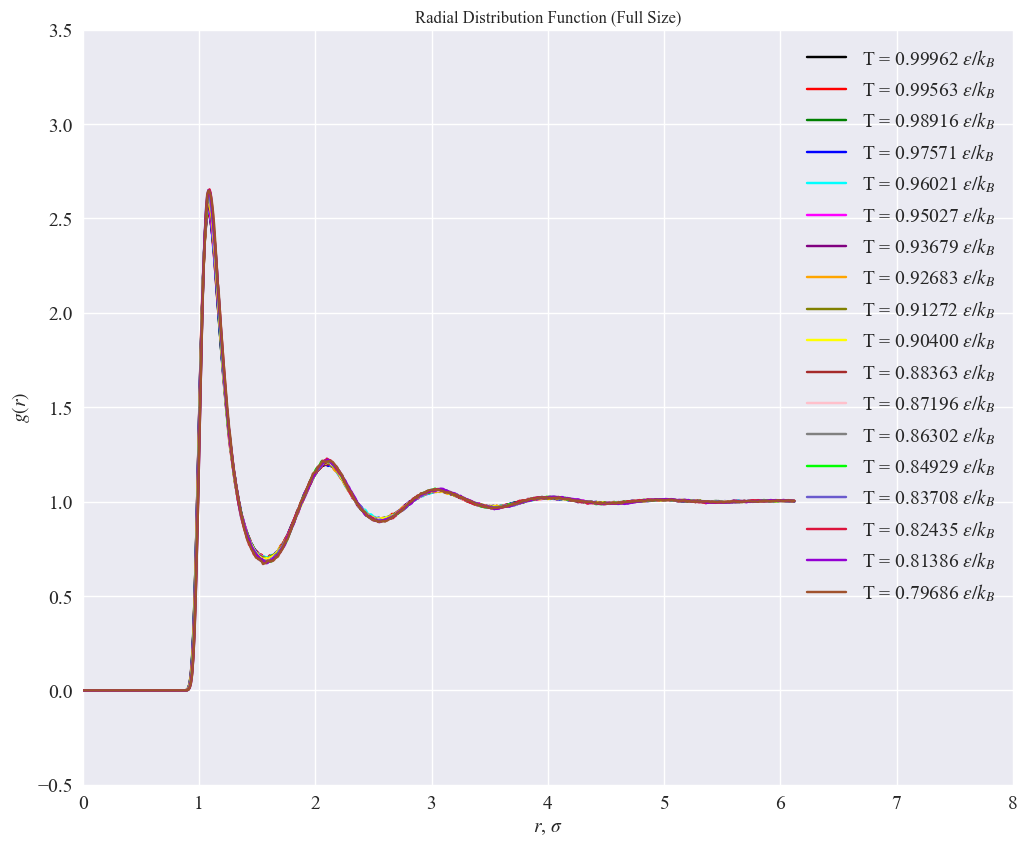

In [9]:
fig, ax = plt.subplots(figsize=(12, 10))
for i, temperature in enumerate(temperatures):
    current_rdf = rdf_data[f'{temperature:.5f}']
    ax.plot(
        rdf_data['radius'],
        current_rdf,
        label=f'T = {temperature:.5f} $\epsilon / k_B $',
        color=COLORS[i],
    );
    
ax.set_xlabel('$r$, $\sigma$');
ax.set_ylabel('$g(r)$');
ax.set_xlim(
    left=0, 
    right=8,
);
ax.set_ylim(
    bottom=-0.5, 
    top=3.5,
);
ax.set_title('Radial Distribution Function (Full Size)');
ax.legend();

save_plot(f'rdf_full_size_{PLOT_FILENAME_POSTFIX}.png')

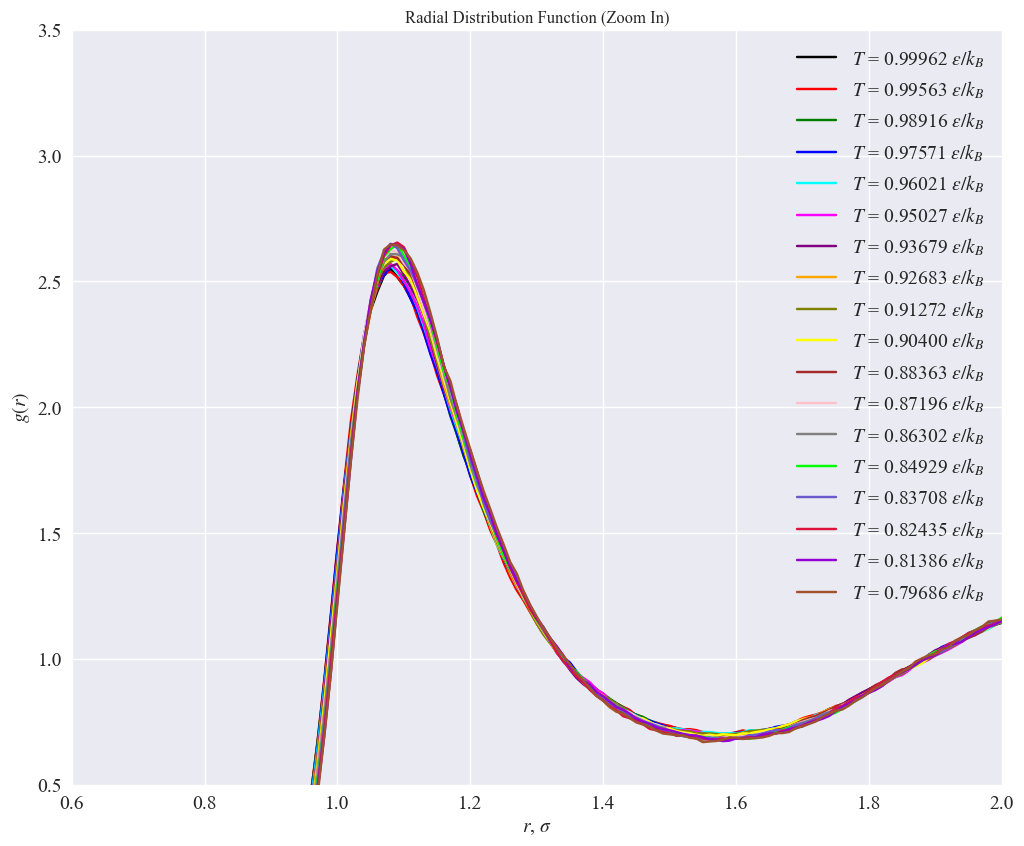

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))
for i, temperature in enumerate(temperatures):
    current_rdf = rdf_data[f'{temperature:.5f}']
    ax.plot(
        rdf_data['radius'],
        rdf_data[f'{temperature:.5f}'],
        label=fr'$T$ = {temperature:.5f} $\epsilon / k_B $',
        color=COLORS[i],
    );
    
ax.set_xlabel('$r$, $\sigma$');
ax.set_ylabel('$g(r)$');
ax.set_xlim(
    left=0.6, 
    right=2,
);
ax.set_ylim(
    bottom=0.5,
    top=3.5, 
);
ax.set_title('Radial Distribution Function (Zoom In)');
ax.legend();

save_plot(f'rdf_zoom_in_{PLOT_FILENAME_POSTFIX}.png')

#### Создаём таблицу со значениями RDF, где строка соответствует значению температуры $T$, а столбец - расстоянию $r$.

In [11]:
rdf_points = deepcopy(rdf_data)

rdf_points.index = rdf_points['radius']
rdf_points = rdf_points.drop(columns=['radius'])
rdf_points = rdf_points.T[::-1]
rdf_points

radius,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,...,6.03,6.04,6.05,6.06,6.07,6.08,6.09,6.10,6.11,6.12
0.79686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.005076,1.004279,1.006004,1.005825,1.006622,1.006204,1.005157,1.004797,1.004453,1.003614
0.81386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.008596,1.006727,1.006849,1.006694,1.007623,1.006596,1.005243,1.005512,1.004371,1.001300
0.82435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.005256,1.004343,1.006771,1.005670,1.003683,1.002669,1.003794,1.001743,1.002365,1.003717
0.83708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.002858,1.003487,1.002639,1.002294,1.001504,1.002489,1.003906,1.004377,1.002273,1.002142
0.84929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.006457,1.004896,1.005194,1.004209,1.003012,1.003053,1.003259,1.002286,1.002260,1.001005
0.86302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004181,1.003950,1.002760,1.002391,1.001804,1.001673,1.001064,1.003435,1.004132,1.004688
0.87196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.002390,1.002349,1.001924,1.002703,1.001301,1.001699,1.001463,0.999682,1.001888,1.001817
0.88363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.002367,1.002520,1.002548,1.001484,1.002983,1.002836,1.002390,1.002135,1.002676,1.001236
0.90400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.001849,1.004608,1.003384,1.002330,1.003507,1.005792,1.004912,1.004076,1.001845,1.003170
0.91272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004706,1.004157,1.003283,1.001744,1.004049,1.002987,1.005154,1.003428,1.002232,1.002725


#### К каждому столбцу $g(T, r=r_i)$ применим алгоритм линейной регрессии. То есть будем искать функции вида $g_i = k_iT + b_i$ Ниже показаны значения расстояния между частицами $r_i$, соответствующие значения коэффициентов $k_i, b_i$ и значения среднеквадратичной ошибки RMSE

In [12]:
predicted_points = {key: [] for key in test_temperatures}
for column in rdf_points.columns:
    if not (rdf_points[column] == 0).all():
        x = rdf_points.index.values.astype(np.float32)
        y = rdf_points[column]
        regressor = LinearRegression()
        regressor.fit(x.reshape((x.size, 1)), y)
        k = regressor.coef_[0]
        b = regressor.intercept_
        training_data = k * x + b
        rmse = mean_squared_error(y, training_data, squared=False)
        
        for key, _ in predicted_points.items():
            new_point = k * key + b
#             new_point = new_point if new_point >= 0.0 else 0.0
            predicted_points[key].append(new_point)
        
        print(f'r = {column:.2f}; k = {k:8.5f}; b = {b:8.5f}; RMSE = {rmse:.5f}')
        
#         fig, ax = plt.subplots(figsize=(10, 5))
#         ax.scatter(x, y, label=fr'r = {column}')
#         ax.plot(x, y, label=fr'r = {column}')
#         ax.plot(x, training_data, label=f'{k:.5f} * x {"+" if b >= 0 else "-"} {abs(b):.5f} (RMSE = {rmse:.5f})')
#         plt.legend()
#         plt.show()
    else:
        for key, _ in predicted_points.items():
            predicted_points[key].append(0.0)

r = 0.86; k =  0.00011; b = -0.00009; RMSE = 0.00001
r = 0.87; k =  0.00034; b = -0.00029; RMSE = 0.00003
r = 0.88; k =  0.00159; b = -0.00130; RMSE = 0.00008
r = 0.89; k =  0.00618; b = -0.00485; RMSE = 0.00014
r = 0.90; k =  0.02167; b = -0.01649; RMSE = 0.00046
r = 0.91; k =  0.06104; b = -0.04516; RMSE = 0.00068
r = 0.92; k =  0.13510; b = -0.09550; RMSE = 0.00135
r = 0.93; k =  0.26409; b = -0.17651; RMSE = 0.00207
r = 0.94; k =  0.45751; b = -0.28784; RMSE = 0.00292
r = 0.95; k =  0.66080; b = -0.36789; RMSE = 0.00472
r = 0.96; k =  0.90396; b = -0.43912; RMSE = 0.00409
r = 0.97; k =  1.06310; b = -0.38501; RMSE = 0.00643
r = 0.98; k =  1.13586; b = -0.21744; RMSE = 0.00669
r = 0.99; k =  1.17299; b =  0.00968; RMSE = 0.00942
r = 1.00; k =  1.04461; b =  0.39825; RMSE = 0.00990
r = 1.01; k =  0.94080; b =  0.76098; RMSE = 0.01094
r = 1.02; k =  0.66728; b =  1.25826; RMSE = 0.01223
r = 1.03; k =  0.34804; b =  1.76522; RMSE = 0.00987
r = 1.04; k =  0.17492; b =  2.10568; RMSE = 0

r = 3.71; k =  0.02366; b =  0.96628; RMSE = 0.00308
r = 3.72; k =  0.02955; b =  0.96258; RMSE = 0.00281
r = 3.73; k =  0.01115; b =  0.98071; RMSE = 0.00250
r = 3.74; k =  0.01477; b =  0.97840; RMSE = 0.00352
r = 3.75; k =  0.00513; b =  0.98973; RMSE = 0.00314
r = 3.76; k =  0.00937; b =  0.98777; RMSE = 0.00359
r = 3.77; k =  0.01306; b =  0.98631; RMSE = 0.00325
r = 3.78; k =  0.00422; b =  0.99575; RMSE = 0.00268
r = 3.79; k = -0.00257; b =  1.00305; RMSE = 0.00283
r = 3.80; k = -0.00691; b =  1.00924; RMSE = 0.00272
r = 3.81; k = -0.00308; b =  1.00702; RMSE = 0.00182
r = 3.82; k = -0.00220; b =  1.00724; RMSE = 0.00180
r = 3.83; k = -0.00722; b =  1.01424; RMSE = 0.00275
r = 3.84; k = -0.01715; b =  1.02364; RMSE = 0.00249
r = 3.85; k = -0.01962; b =  1.02813; RMSE = 0.00240
r = 3.86; k = -0.02186; b =  1.03076; RMSE = 0.00218
r = 3.87; k = -0.01703; b =  1.02765; RMSE = 0.00230
r = 3.88; k = -0.01343; b =  1.02532; RMSE = 0.00276
r = 3.89; k = -0.01793; b =  1.03054; RMSE = 0

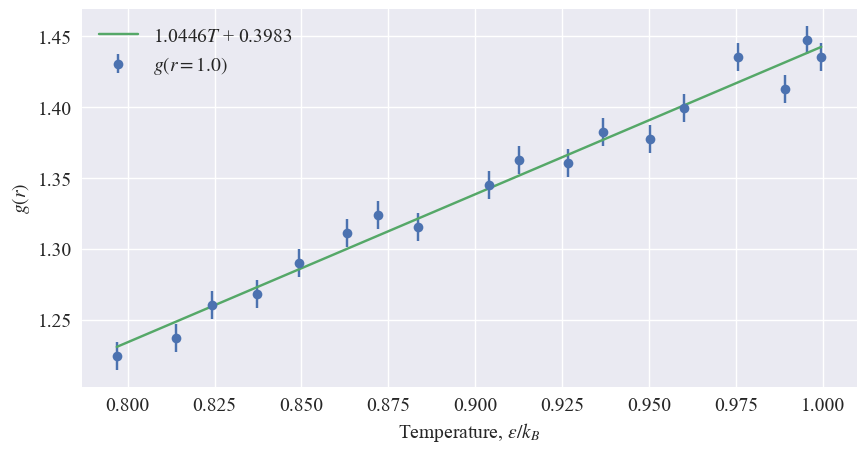

In [13]:
for column in (1.0, ):
    x = rdf_points.index.values.astype(np.float32)
    y = rdf_points[column]
    regressor = LinearRegression()
    regressor.fit(x.reshape((x.size, 1)), y)
    k = regressor.coef_[0]
    b = regressor.intercept_
    training_data = k * x + b
    rmse = mean_squared_error(y, training_data, squared=False)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.errorbar(
        x, 
        y, 
        yerr=rmse,
        fmt='o',
        label=fr'$g(r = {column})$',
    )
    ax.plot(
        x, 
        training_data, 
        label=fr'{k:.4f}$T$ {"+" if b >= 0 else "-"} {abs(b):.4f}'
    )
    ax.legend()
    ax.set_xlabel(r'Temperature, $\epsilon / k_B$');
    ax.set_ylabel('$g(r)$');
    save_plot(f'rdf_point_{PLOT_FILENAME_POSTFIX}.png')

#### Графики функций радиального распределения $g(\textbf{r})$ при различных температурах (direct - посчитанные напрямую, predicted - предсказанные)

0.86 -2.7434439107310024e-05
0.87 -8.274585125036537e-05
0.88 -0.0003425909206271172
0.89 -0.0011471312493085864
0.9 -0.0034904547035694133
0.91 -0.0085375152528286
0.92 -0.014436909556388863
0.93 -0.018053856492042553
0.94 -0.0133367359638214

0.86 -3.834127710433677e-05
0.87 -0.00011660211021080613
0.88 -0.0005020468961447477
0.89 -0.0017650953959673643
0.9 -0.005657847970724106
0.91 -0.014641517773270607
0.92 -0.027946725487709045
0.93 -0.044463008642196655
0.94 -0.05908811092376709
0.95 -0.03749391436576843

0.86 -4.9248115101363506e-05
0.87 -0.0001504583691712469
0.88 -0.0006615028716623782
0.89 -0.0023830595426261422
0.9 -0.007825241237878798
0.91 -0.020745520293712613
0.92 -0.041456541419029234
0.93 -0.07087216079235076
0.94 -0.10483948588371275
0.95 -0.10357347726821897
0.96 -0.07753576636314391

0.86 -6.015495309839025e-05
0.87 -0.00018431462813168765
0.88 -0.000820958847180009
0.89 -0.003001023689284921
0.9 -0.009992634505033494
0.91 -0.026849522814154626
0.92 -0.054966357350

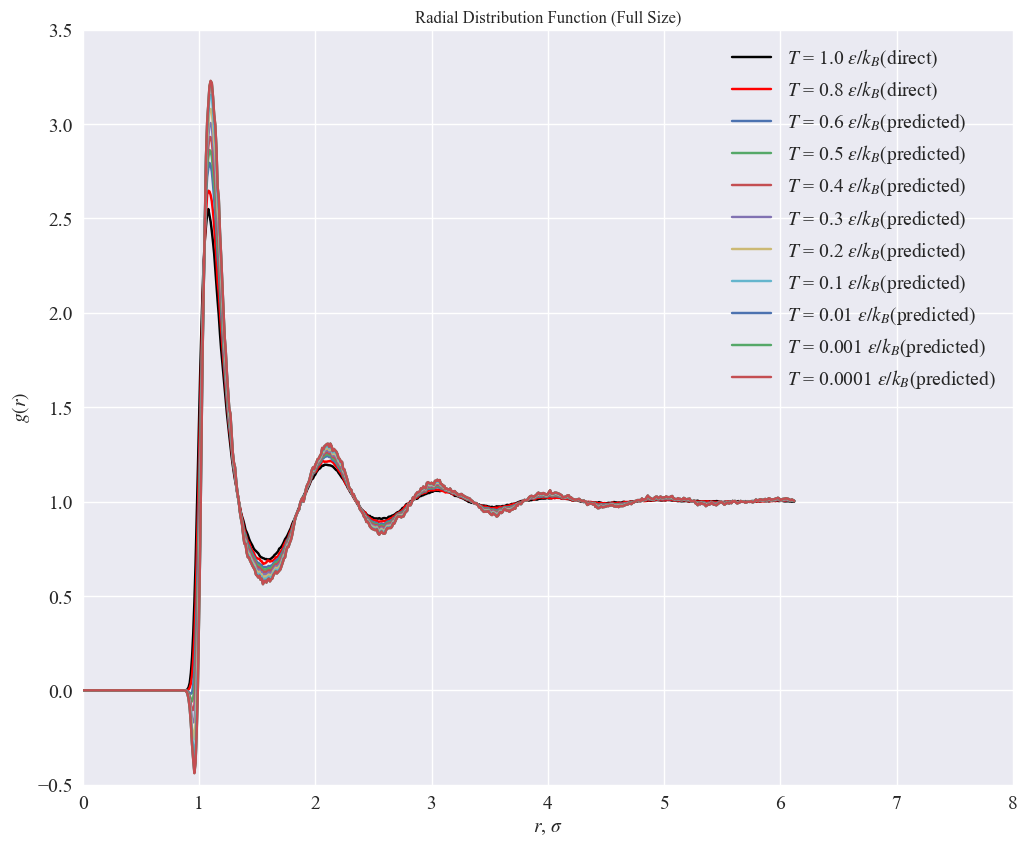

In [14]:
for key, value in predicted_points.items():
    predicted_points[key] = np.array(value)

fig, ax = plt.subplots(figsize=(12, 10))

for i, temperature in enumerate((temperatures[0], temperatures[-1])):
    current_rdf = rdf_data[f'{temperature:.5f}']
    ax.plot(
        rdf_data['radius'],
        current_rdf,
        label=fr'$T$ = {temperature:.1f} $\epsilon / k_B $(direct)',
        color=COLORS[i],
    );

for key, value in predicted_points.items():
    for i, r in enumerate(rdf_points.columns.values):
        if value[i] < 0:
            print(r, value[i])
    print()
    ax.plot(rdf_points.columns.values, value, label=fr'$T$ = {key} $\epsilon / k_B $(predicted)');
    
ax.set_xlabel('$r$, $\sigma$');
ax.set_ylabel('$g(r)$');
ax.set_xlim(
    left=0, 
    right=8,
);
ax.set_ylim(
    bottom=-0.5, 
    top=3.5,
);
ax.set_title('Radial Distribution Function (Full Size)')
ax.legend();

save_plot(f'rdf_with_predicted_full_size_{PLOT_FILENAME_POSTFIX}.png')

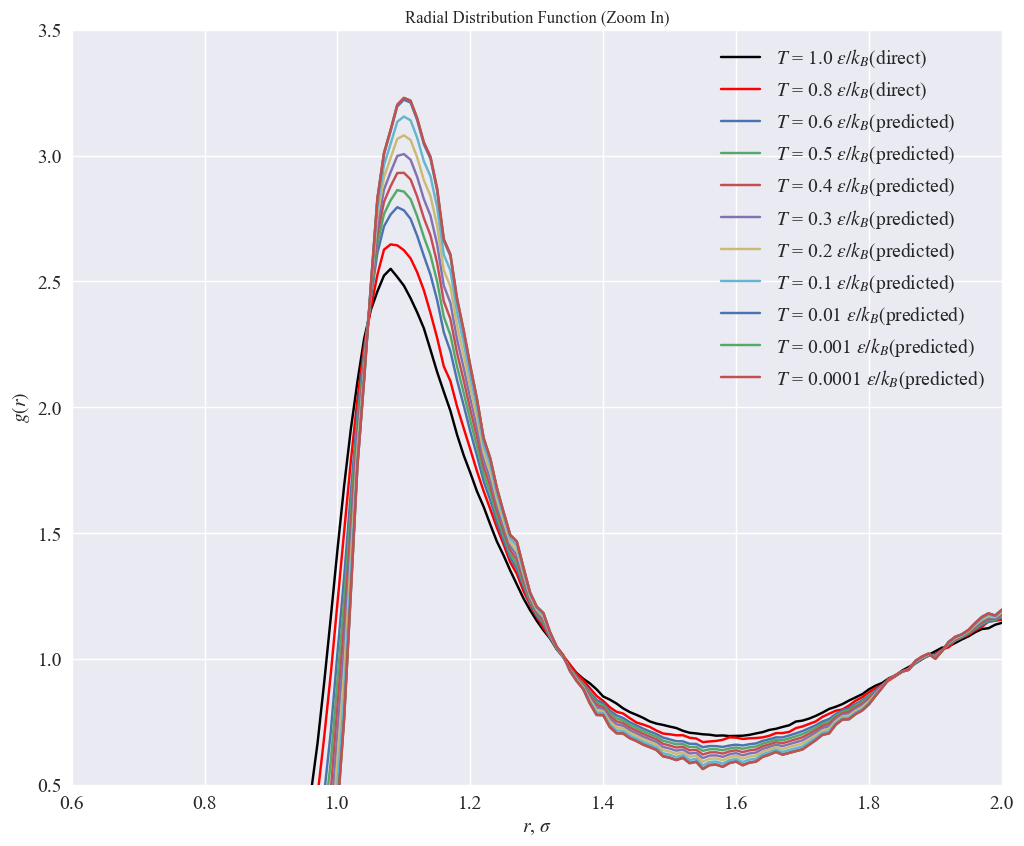

In [15]:
for key, value in predicted_points.items():
    predicted_points[key] = np.array(value)

fig, ax = plt.subplots(figsize=(12, 10))

for i, temperature in enumerate((temperatures[0], temperatures[-1])):
    current_rdf = rdf_data[f'{temperature:.5f}']
    ax.plot(
        rdf_data['radius'],
        rdf_data[f'{temperature:.5f}'],
        label=fr'$T$ = {temperature:.1f} $\epsilon / k_B $(direct)',
        color=COLORS[i],
    );

for key, value in predicted_points.items():
    ax.plot(rdf_points.columns.values, value, label=fr'$T$ = {key} $\epsilon / k_B $(predicted)');
    
ax.set_xlabel('$r$, $\sigma$');
ax.set_ylabel('$g(r)$');
ax.set_xlim(
    left=0.6, 
    right=2,
);
ax.set_ylim(
    bottom=0.5,
    top=3.5, 
);
ax.set_title('Radial Distribution Function (Zoom In)')
ax.legend();

save_plot(f'rdf_with_predicted_zoom_in_{PLOT_FILENAME_POSTFIX}.png')

#### Временная зависимость среднеквадратичного смещения $\left<\Delta r^2(t)\right>$ при различных температурах

$$\left<\Delta r^2(t)\right>=\dfrac{1}{N}\sum_{i=1}^{N}{\left|\textbf{r}_i(t)-\textbf{r}_i(0)\right|^2}$$

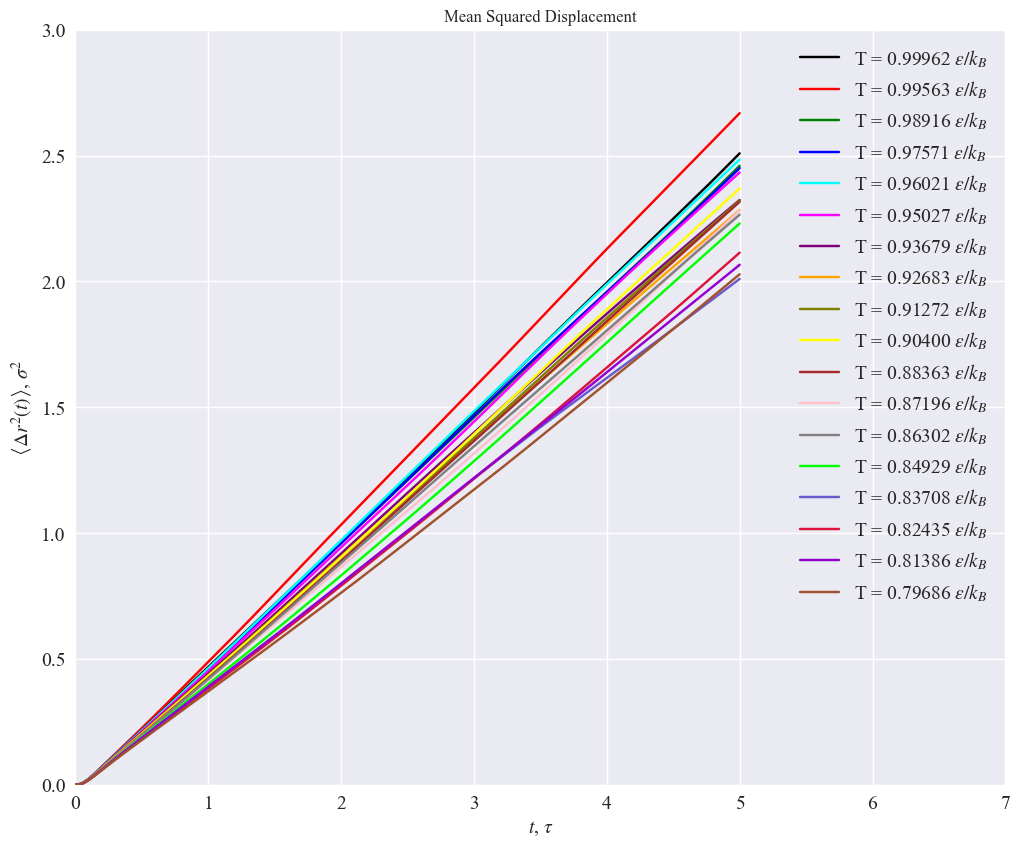

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))
for i, temperature in enumerate(temperatures):
    ax.plot(
        msd_data['time'],
        msd_data[f'{temperature:.5f}'], 
        label=f'T = {temperature:.5f} $\epsilon / k_B $',
        color=COLORS[i],
    );
    
ax.set_xlabel(r'$t$, $\tau $');
ax.set_ylabel(r'$\left<\Delta r^2(t)\right>$, $\sigma^2$');
ax.set_xlim(
    left=0, 
    right=7,
);
ax.set_ylim(
    bottom=0, 
    top=3,
);
ax.set_title('Mean Squared Displacement');
ax.legend();

save_plot(f'msd_{PLOT_FILENAME_POSTFIX}.png')

#### Временная зависимость автокорреляционнной функции скорости $\Psi(t)$ при различных температурах

$$\Psi(t) = \dfrac{1}{N}\left<\sum_{j=1}^N{\vec{v}_j(t)\vec{v}_j(0)}\right>$$

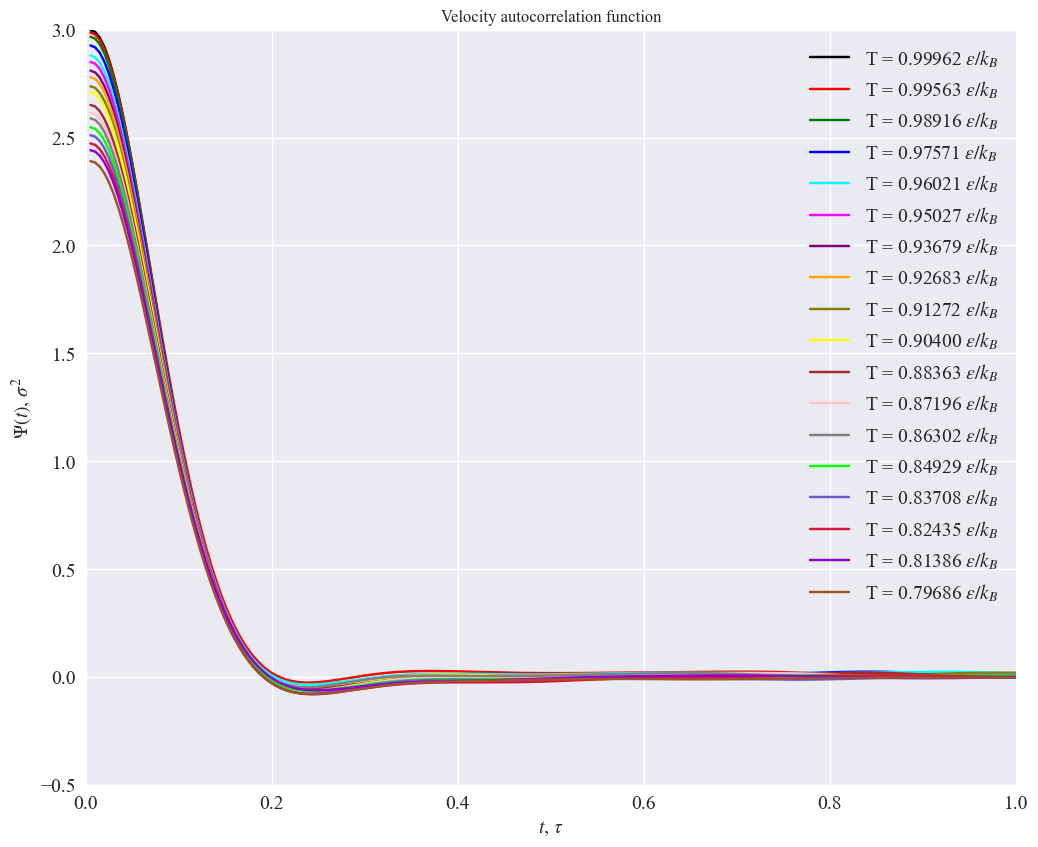

In [17]:
fig, ax = plt.subplots(figsize=(12, 10))

for i, temperature in enumerate(temperatures):
    ax.plot(
        vel_autocor_data['time'],
        vel_autocor_data[f'{temperature:.5f}'], 
        label=f'T = {temperature:.5f} $\epsilon / k_B $',
        color=COLORS[i],
    );
    
ax.set_xlabel(r'$t$, $\tau $');
ax.set_ylabel(r'$\Psi(t)$, $\sigma^2$');
ax.set_xlim(
    left=0, 
    right=1,
);
ax.set_ylim(
    bottom=-0.5, 
    top=3,
);
ax.set_title('Velocity autocorrelation function')
ax.legend();

save_plot(f'vel_autocorr_{PLOT_FILENAME_POSTFIX}.png')

#### Временная зависимость коэффициента самодиффузии $D$, вычисленного через соотношение Эйнштейна, при различных температурах

$$D_E(t)=\dfrac{\left<\left<\Delta r^2\right>\right>}{6t}=\dfrac{1}{6tN}\left<\sum_{i=1}^{N}\left|\textbf{r}_i(t)-\textbf{r}_i(0)\right|^2\right>$$

$$D=\lim_{t\rightarrow\infty}{D_E(t)}$$

In [18]:
einstein_diffusion = np.zeros(len(temperatures), dtype=np.float)
green_kubo_diffusion = np.zeros(len(temperatures), dtype=np.float)

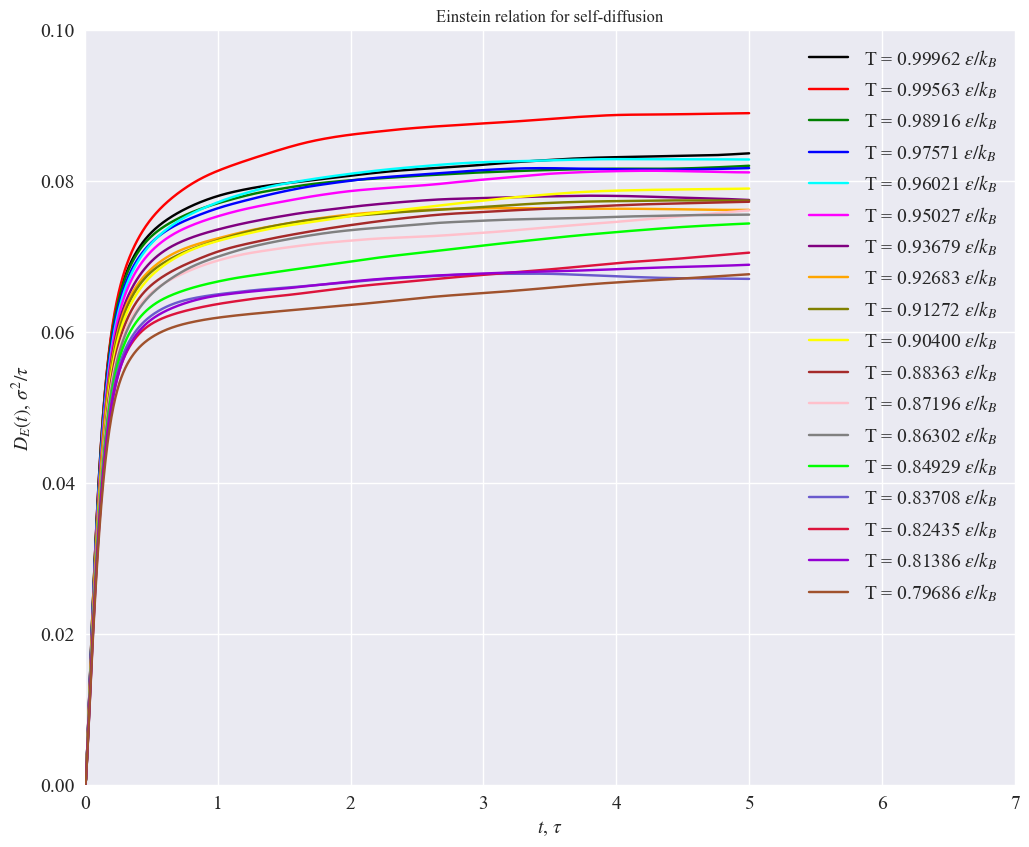

In [19]:
fig, ax = plt.subplots(figsize=(12, 10))

for i, temperature in enumerate(temperatures):
    diff_data = einstein_diffusion_data[f'{temperature:.5f}'].values
    ax.plot(
        einstein_diffusion_data['time'].values,
        diff_data, 
        label=f'T = {temperature:.5f} $\epsilon / k_B $',
        color=COLORS[i],
    );
    einstein_diffusion[i] = diff_data[-1]
    
ax.set_xlabel(r'$t$, $\tau$');
ax.set_ylabel(r'$D_E(t)$, $\sigma^2 / \tau$');
ax.set_xlim(
    left=0, 
    right=7,
);
ax.set_ylim(
    bottom=0, 
    top=0.10,
);
ax.set_title('Einstein relation for self-diffusion')
ax.legend();

save_plot(f'diffusion_einstein_{PLOT_FILENAME_POSTFIX}.png')

#### Временная зависимость коэффициента самодиффузии $D$, вычисленного через соотношение Грина-Кубо, при различных температурах

$$D_{GK}(t)=\dfrac{1}{3}\int_{0}^{t}{\Psi(\tau)d\tau}=\dfrac{1}{3N}\int_{0}^{t}{\left<\sum_{j=1}^N{\vec{v}_j(\tau)\vec{v}_j(0)}\right>d\tau}$$

$$D=\lim_{t\rightarrow\infty}{D_{GK}(t)}$$

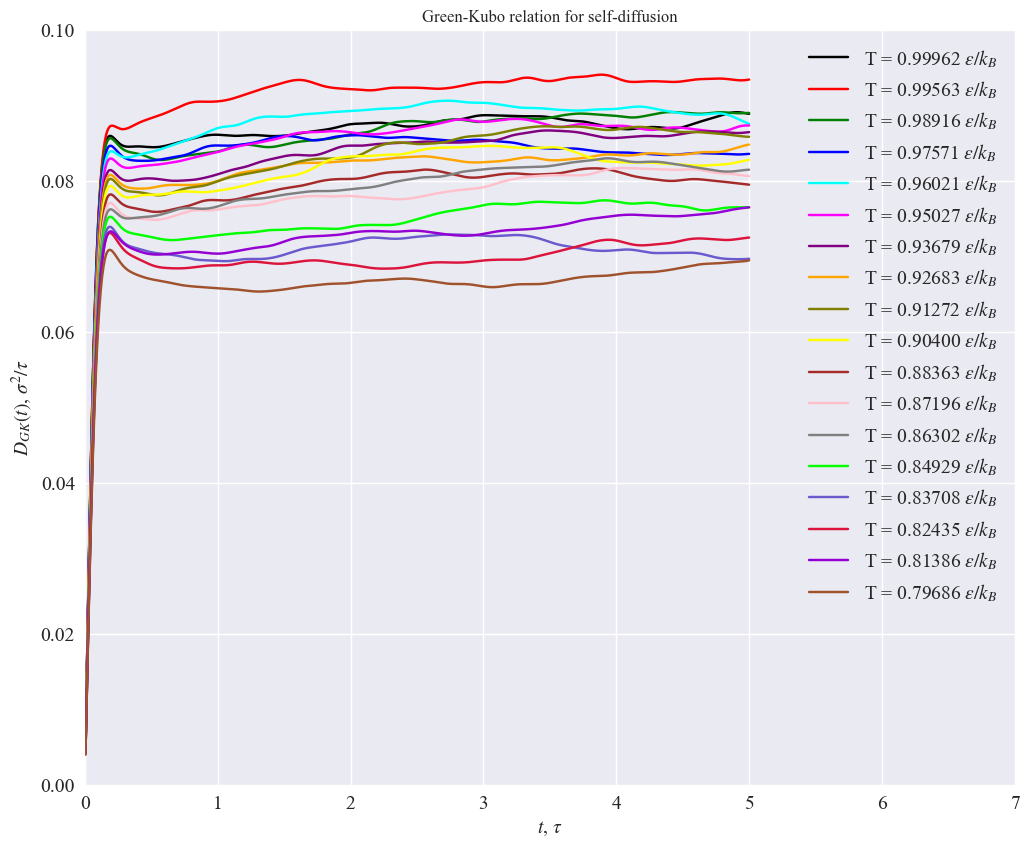

In [20]:
fig, ax = plt.subplots(figsize=(12, 10))

for i, temperature in enumerate(temperatures):
    diff_data = green_kubo_diffusion_data[f'{temperature:.5f}'].values
    ax.plot(
        green_kubo_diffusion_data['time'].values,
        diff_data, 
        label=f'T = {temperature:.5f} $\epsilon / k_B $',
        color=COLORS[i],
    );
    green_kubo_diffusion[i] = diff_data[-1]
    
ax.set_xlabel(r'$t$, $\tau$');
ax.set_ylabel(r'$D_{GK}(t)$, $\sigma^2 / \tau$');
ax.set_xlim(
    left=0, 
    right=7,
);
ax.set_ylim(
    bottom=0, 
    top=0.10,
);
ax.set_title('Green-Kubo relation for self-diffusion')
ax.legend();

save_plot(f'diffusion_green_kubo_{PLOT_FILENAME_POSTFIX}.png')

#### Сравнение коэффициентов самодиффузии, вычисленных через соотношения Эйнштейна и Грина-Кубо

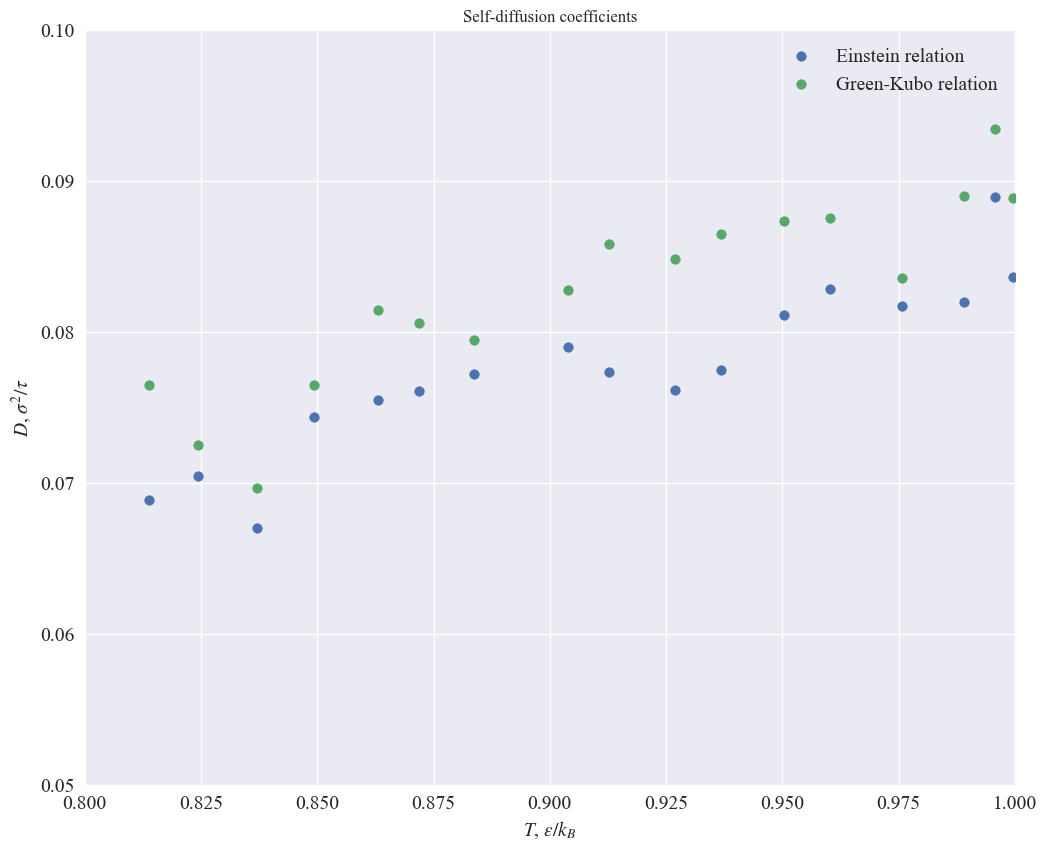

In [21]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.scatter(
    temperatures,
    einstein_diffusion, 
    label='Einstein relation',
);
ax.scatter(
    temperatures,
    green_kubo_diffusion, 
    label='Green-Kubo relation',
); 
ax.set_xlabel(r'$T$, $\epsilon / k_B $');
ax.set_ylabel(r'$D$, $\sigma^2 / \tau$');
ax.set_xlim(
    left=0.8, 
    right=1,
);
ax.set_ylim(
    bottom=0.05, 
    top=0.10,
);
ax.set_title('Self-diffusion coefficients')
ax.legend(markerscale=1);


save_plot(f'diffusion_comparing_{PLOT_FILENAME_POSTFIX}.png')

k = 0.084; b = 0.001; RMSE = 0.002


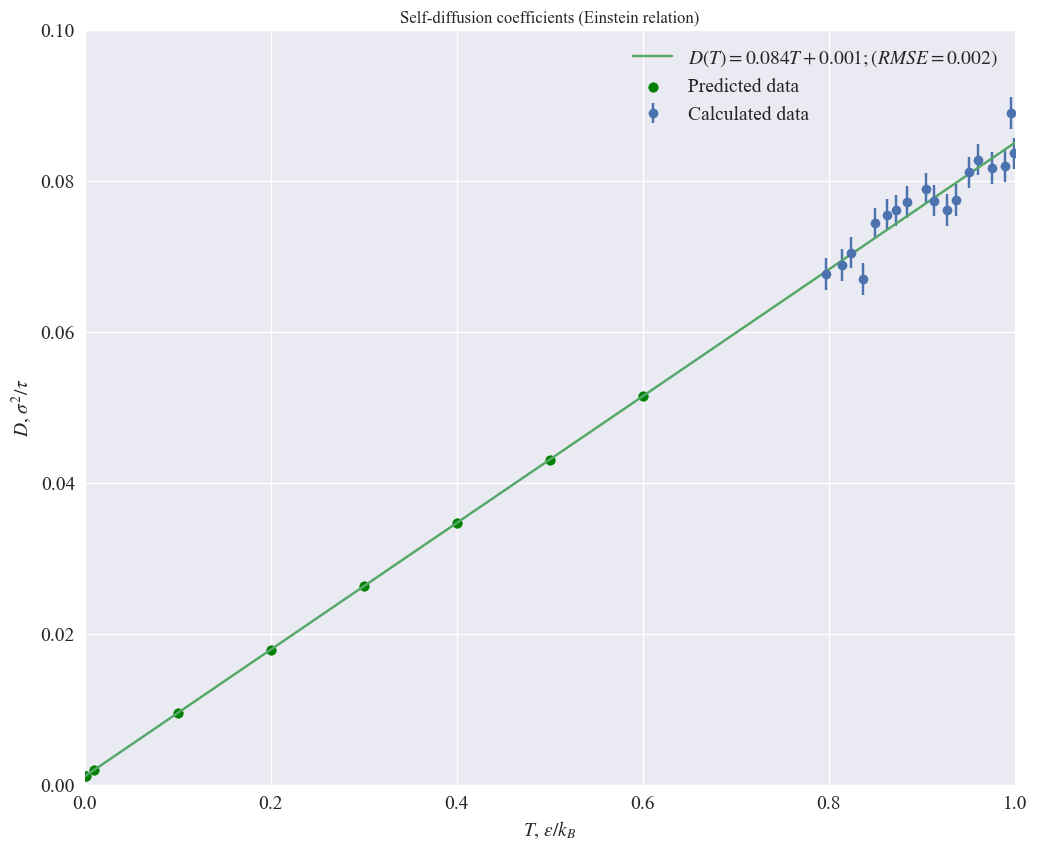

k = 0.096; b = -0.005; RMSE = 0.003


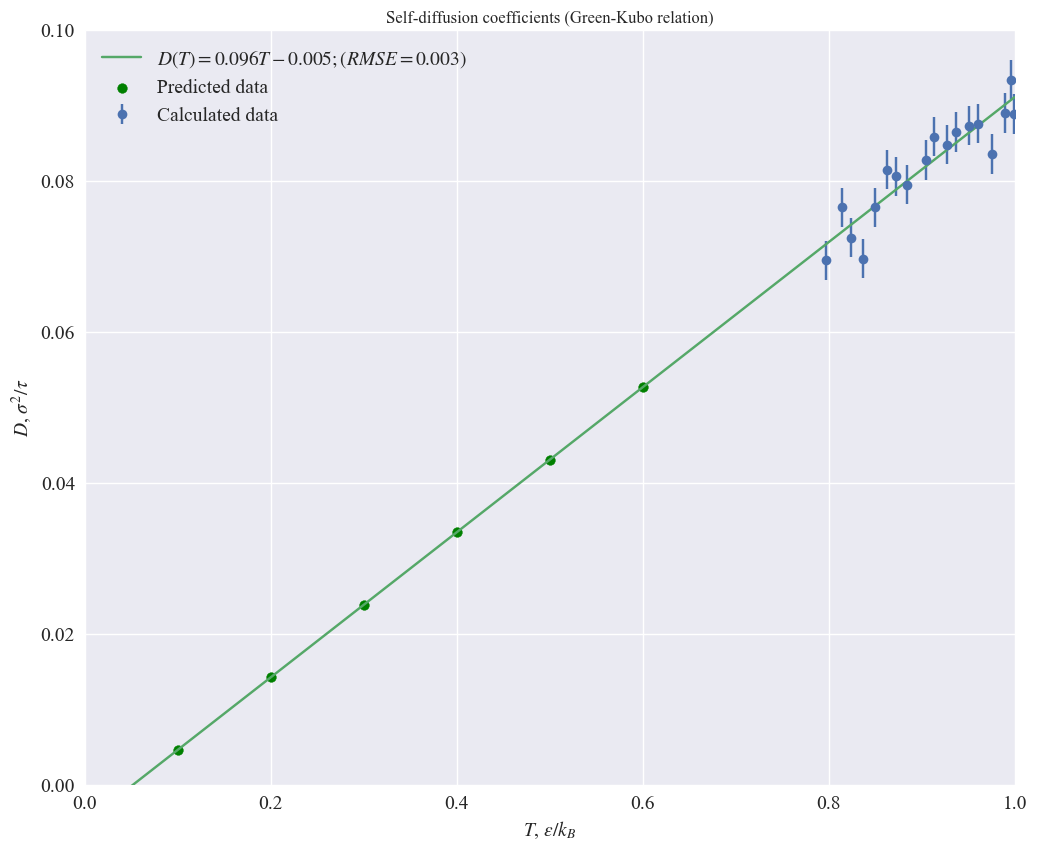

In [22]:
predicted_points = {key: [] for key in test_temperatures}

test_temperatures = np.array(test_temperatures)
for i, data in enumerate((einstein_diffusion, green_kubo_diffusion)):
    x = np.array(temperatures, dtype=np.float32)
    y = data
    regressor = LinearRegression()
    regressor.fit(x.reshape((x.size, 1)), y)
    k = regressor.coef_[0]
    b = regressor.intercept_
    training_data = k * x + b
    rmse = mean_squared_error(y, training_data, squared=False)

    for key, _ in predicted_points.items():
        predicted_points[key].append(k * key + b)
    print(f'k = {k:5.3f}; b = {b:5.3f}; RMSE = {rmse:.3f}')
        
    fig, ax = plt.subplots(figsize=(12, 10));
    ax.set_title(f"Self-diffusion coefficients ({'Einstein relation' if i == 0 else 'Green-Kubo relation'})");
    ax.errorbar(x, y, yerr=rmse, fmt='o', label='Calculated data');
    ax.scatter(test_temperatures, k * test_temperatures + b, label='Predicted data', color='green');
    x = np.linspace(0, x.max(), 10)
    ax.plot(x, k * x + b, label=fr'$D(T) = {k:.3f}T {"+" if b >= 0 else "-"} {abs(b):.3f}; (RMSE = {rmse:.3f})$');
    ax.set_xlabel(r'$T$, $\epsilon / k_B $');
    ax.set_ylabel(r'$D$, $\sigma^2 / \tau$');
    ax.set_xlim(
        left=0, 
        right=1,
    );
    ax.set_ylim(
        bottom=0, 
        top=0.10,
    );
    ax.legend(markerscale=1);
    save_plot(f"diffusion_{'einstein' if i == 0 else 'green_kubo'}_fitted_{PLOT_FILENAME_POSTFIX}.png")
    plt.show();

#### Извлечение параметров системы из файла

In [23]:
system_parameters = pd.read_csv(PARAMETERS_FILENAME, sep=';')

for column in system_parameters.columns:
    system_parameters[column] = system_parameters[column].round(5)

system_parameters

,temperature,pressure,system_kinetic_energy,potential_energy,total_energy,virial,msd,diffusion
0,1.00000,-2.18978,2057.2104,-7984.3115,-5927.1010,-16190.5910,0.00007,0.00250
1,0.99961,-2.17743,2055.6580,-7977.0225,-5921.3643,-16119.3910,0.00030,0.00500
2,0.99924,-2.15447,2054.0195,-7961.4385,-5907.4190,-15989.5240,0.00067,0.00749
3,0.99881,-2.12543,2051.9840,-7946.1475,-5894.1636,-15825.2820,0.00120,0.00999
4,0.99824,-2.08934,2049.2996,-7929.9370,-5880.6377,-15620.8950,0.00187,0.01247
...,...,...,...,...,...,...,...,...
39995,0.80081,0.31623,1644.8289,-6843.5220,-5198.6934,-1545.7318,74.32584,0.06194
39996,0.80038,0.31980,1643.1816,-6840.6694,-5197.4880,-1522.7350,74.32827,0.06194
39997,0.80003,0.32547,1641.8594,-6836.3203,-5194.4610,-1488.8165,74.33072,0.06195
39998,0.79976,0.33280,1640.8104,-6830.8447,-5190.0340,-1446.3120,74.41119,0.06201


In [24]:
times = (system_parameters.index + 1) * 0.005

#### Зависимость температуры системы от времени

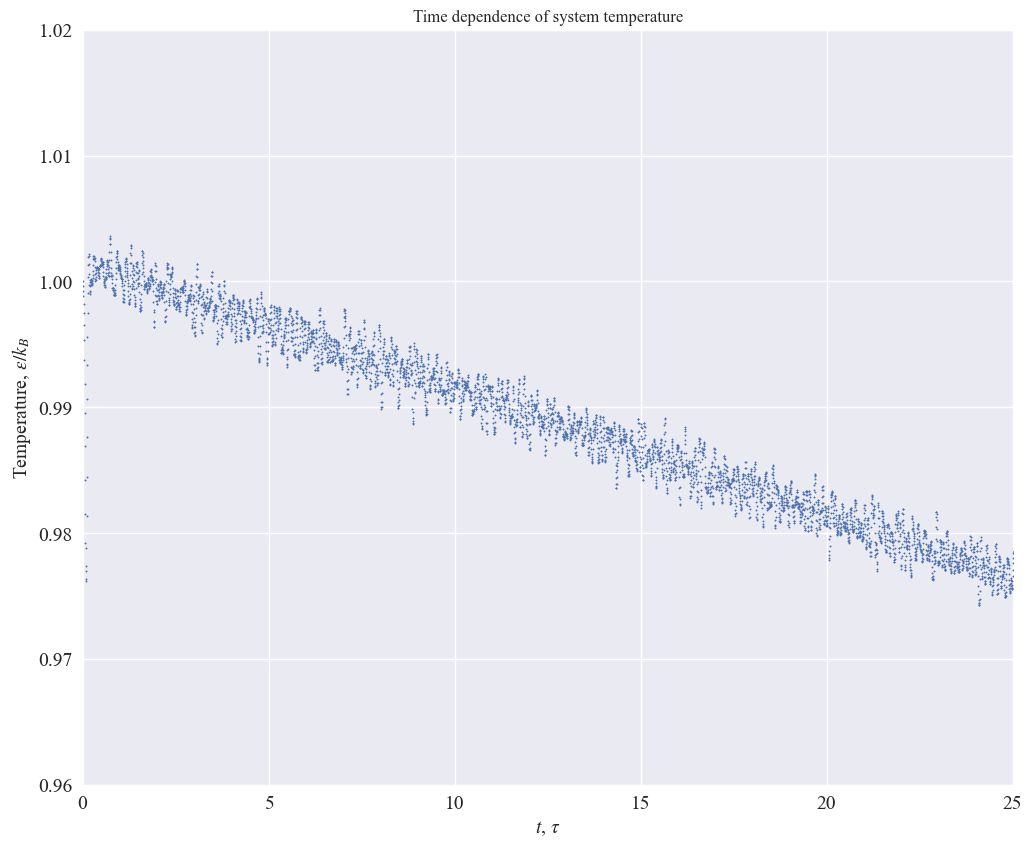

In [25]:
fig, ax = plt.subplots(figsize=(12, 10));
ax.scatter(
    times,
    system_parameters['temperature'],
    s=1,
);
ax.set_xlabel(r'$t$, $\tau$');
ax.set_ylabel(r'Temperature, $\epsilon / k_B$');
ax.set_xlim(
    left=0,
    right=25,
);
ax.set_ylim(
    bottom=0.96,
    top=1.02,
);
ax.set_title(f"Time dependence of system temperature");
save_plot(f'temperature_{PLOT_FILENAME_POSTFIX}.png')

#### Зависимость давления системы от времени

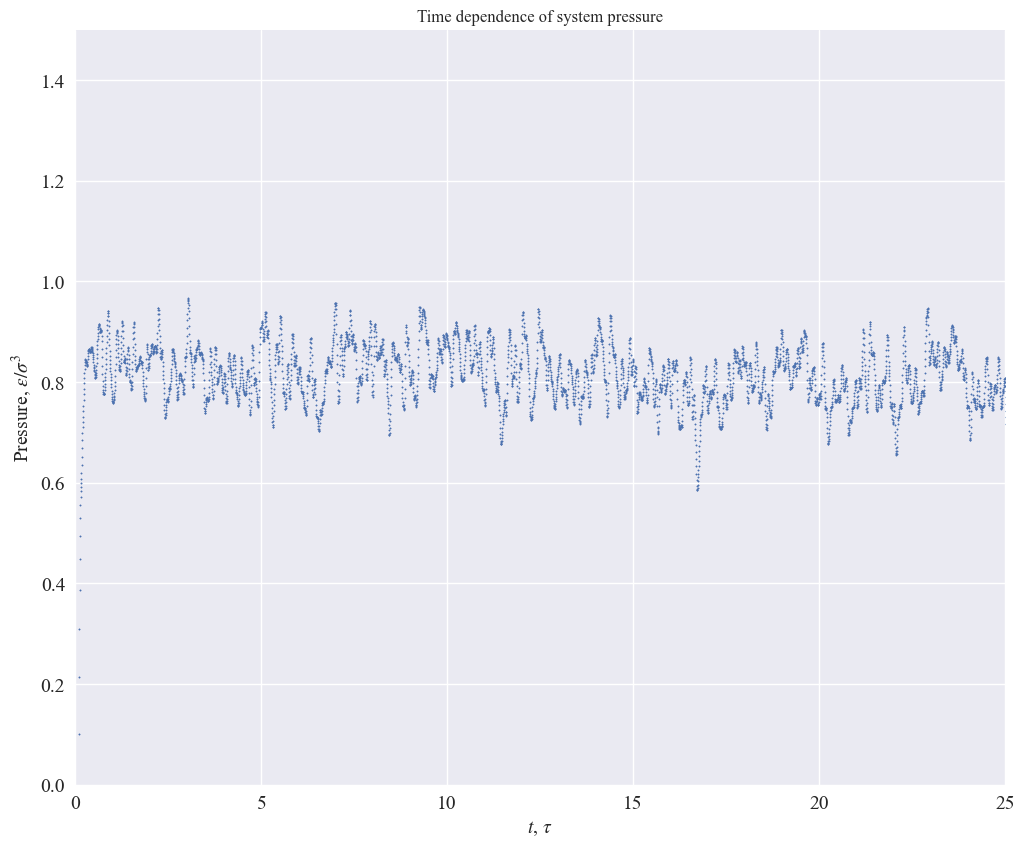

In [26]:
fig, ax = plt.subplots(figsize=(12, 10));
ax.scatter(
    times,
    system_parameters['pressure'],
    s=1,
);
ax.set_xlabel(r'$t$, $\tau$');
ax.set_ylabel(r'Pressure, $\epsilon / \sigma^3 $');

ax.set_xlim(
    left=0,
    right=25,
);
ax.set_ylim(
    bottom=0,
    top=1.5,
);
ax.set_title(f"Time dependence of system pressure");
save_plot(f'pressure_{PLOT_FILENAME_POSTFIX}.png')

#### Зависимость энергии системы от времени

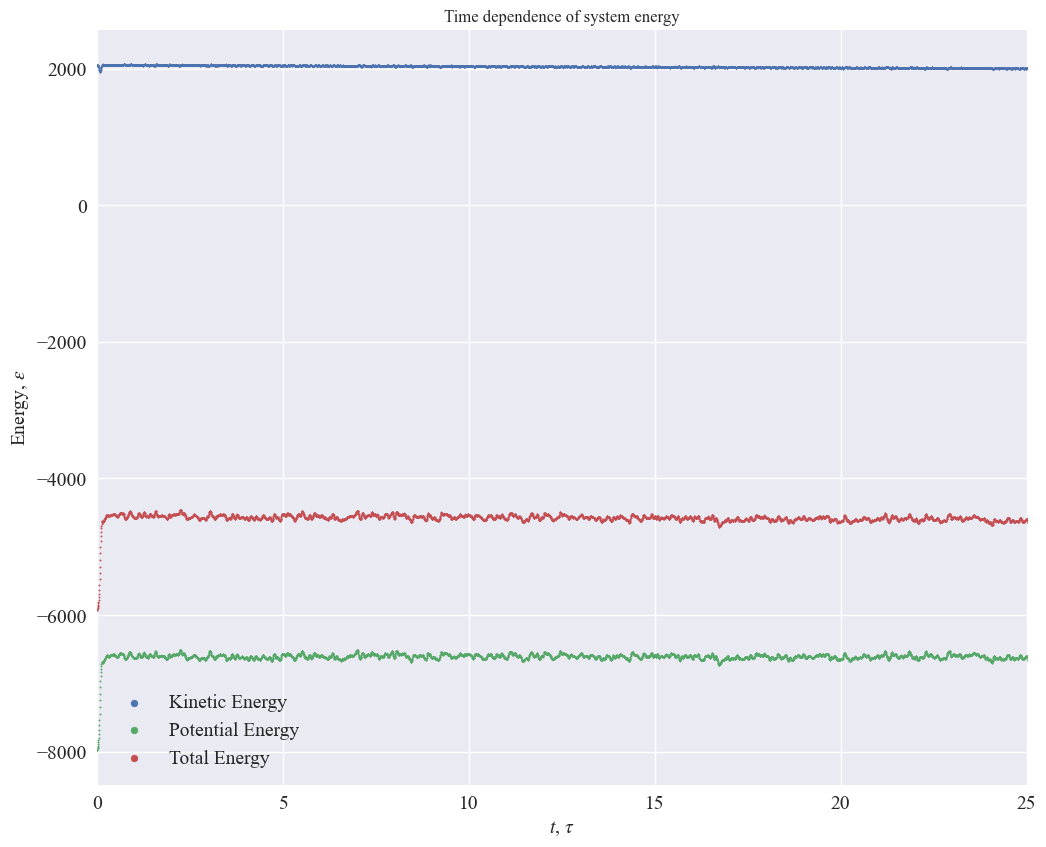

In [27]:
fig, ax = plt.subplots(figsize=(12, 10));
ax.scatter(
    times,
    system_parameters['system_kinetic_energy'],
    s=1,
    label='Kinetic Energy',
);
ax.scatter(
    times,
    system_parameters['potential_energy'],
    s=1,
    label='Potential Energy',
);
ax.scatter(
    times,
    system_parameters['total_energy'],
    s=1,
    label='Total Energy',
);

ax.set_xlabel(r'$t$, $\tau$');
ax.set_ylabel(r'Energy, $\epsilon$');
ax.legend(markerscale=5);

ax.set_xlim(
    left=0,
    right=25,
);
ax.set_ylim(
#     bottom=-10000,
#     top=6000,
);
ax.set_title(f"Time dependence of system energy");
save_plot(f'all_energies_{PLOT_FILENAME_POSTFIX}.png')